# Иссследование закономерностей успеха компьютерных игр

Нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as sps

import warnings
warnings.filterwarnings("ignore")

## Шаг 1: Изучение данных

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Таблица содержит 16715 записей и 11 столбцов. В данных есть пропуски, столбцы имеют неудобные названия. Столбец оценок пользователей имеет тип данных - строка, что странно. Давайте обработаем данные.

## Шаг 2: Подготовка данных

Для начала изменим названия столбцов на нижний регистр:

In [3]:
data.columns = ['name','platform','year_of_release','genre','na_sales','eu_sales','jp_sales','other_sales','critic_score','user_score','rating']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Обработка пропусков

Изучим пропуски в name:

In [4]:
data.query("name.isna()")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Эти две записи почти не содержат полезной информации, т.к. не идентифицируют ни жанр, ни игру. Поэтому удалим их. 

Изучим пропуски в year_of_release: 

In [5]:
data = data.dropna(subset=['name']).reset_index(drop=True)
data.query("year_of_release.isna()")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Столбец содержит 269 пропусков. Это менее 2-х процентов данных. Возможно, у некоторых записей просто потеряны данные, а у некоторых год содержится внутри названия игры. Удалять и обрабатывать эти строки не будем.

Теперь займемся заполнением пропусков в оценках критиков. Самый подходящий в данной ситуации способ - заменить пропуски медианным значением по жанру:

In [6]:
data['critic_score'] = data['critic_score'].fillna(data.groupby('genre')['critic_score'].transform('median'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Все пропуски оценок критиков заменены. Теперь разберемся с оценками пользователей. В данных встречается значение tbd - to be determined, которое означает, что оценка еще не готова. Заменим значения tbd  и пропуски на среднее по жанру. Заодно изменим тип данных столбца на числовой.

In [7]:
data.loc[data['user_score'] == 'tbd','user_score'] = np.nan
data['user_score'] = pd.to_numeric(data['user_score'])
data['user_score'] = data['user_score'].fillna(data.groupby('genre')['user_score'].transform('median'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null float64
rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Теперь посмотрим на возрастной рейтинг. Заменить значение на среднее не получится. Попробуем проверить, может некоторые игры указаны несколько раз на разных платформах и на каких-то из них есть рейтинг. Для этого создадим таблицу в которой будут только данные о названии и рейтинге. Затем удалим NaN значения, оставим по 1 строке для каждого названия и заполним пропуски через получившуюся таблицу методом map.

In [8]:
scores = data[['name','rating']].dropna().drop_duplicates('name').set_index('name')
data['rating'] = data['rating'].fillna(data['name'].map(scores['rating']))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null float64
rating             10386 non-null object
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Таким образом удалось заполнить чуть больше 400 строк. Немного, но хоть что-то. Остальные пропуски оставим как есть.

### Замена типов данных

Заменим тип данных year_of_release и critic_score на int.

In [9]:
data['year_of_release'] = data['year_of_release'].astype('Int64')
data['critic_score'] = data['critic_score'].astype('int')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null Int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null int64
user_score         16713 non-null float64
rating             10386 non-null object
dtypes: Int64(1), float64(5), int64(1), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,69,7.7,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,74,7.8,NaN


Теперь все столбцы имеют подходящий тип данных. 

### Добавим суммарные продажи по всем регионам

In [10]:
data['all_sales'] = data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,69,7.7,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,74,7.8,NaN,31.38


Нужный столбец суммарных продаж был добавлен в таблицу. Данные готовы. Пора начать исследование.

## Шаг 3: Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

<BarContainer object of 37 artists>

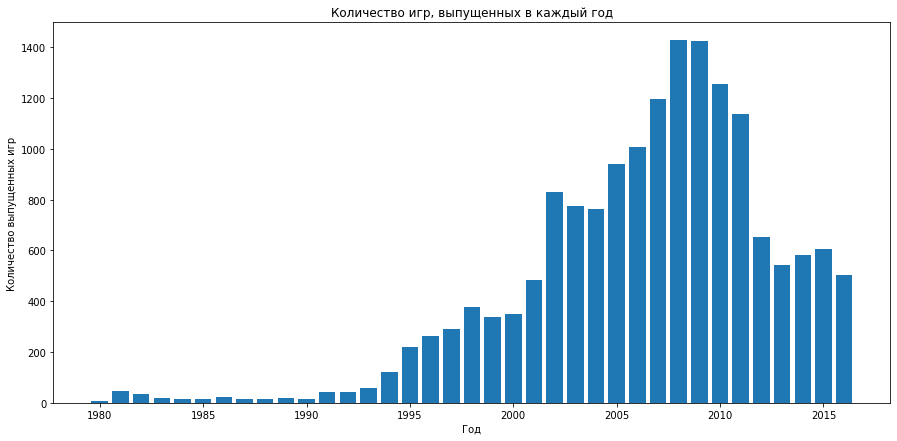

In [11]:
years_count = data.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
plt.figure(figsize=(15,7))
plt.title('Количество игр, выпущенных в каждый год')
plt.xlabel('Год')
plt.ylabel('Количество выпущенных игр')
plt.bar(years_count['year_of_release'], years_count['name'])

### Вывод
По гистограмме видно, что объем игр, выпущенных до 2000-ных намного меньше. Начиная с 2002 года количество выпущенных игр начинает возрастать в разы.

### Выделим актуальные платформы
Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 

In [12]:
platforms_data = data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales', ascending=False).head(10).reset_index()
platforms_data

,platform,all_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85
7,PS4,314.14
8,PSP,294.05
9,PC,259.52


Мы веделили топ-10 платформ по суммарым продажам. Теперь построим распределение по годам.

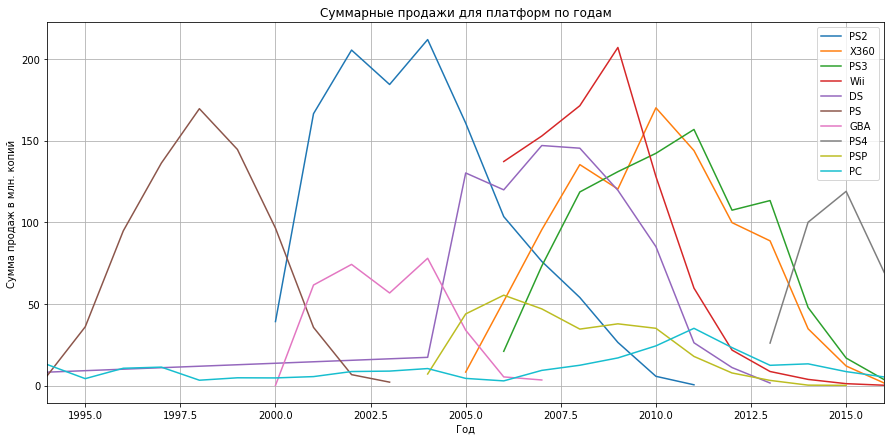

In [13]:
plt.figure(figsize=(15,7))
plt.title('Суммарные продажи для платформ по годам')
for row in platforms_data['platform']:
    platform = data.query("platform == @row").pivot_table(index='year_of_release', values='all_sales', aggfunc='sum').reset_index()
    sb.lineplot(data=platform, x='year_of_release', y='all_sales', label=row)
plt.xlabel('Год')
plt.ylabel('Сумма продаж в млн. копий')
plt.xlim(1994, 2016)
plt.grid()
plt.show()

### Вывод
За какой характерный срок появляются новые и исчезают старые платформы? По графику видно, что период актуальности для платформ составляет примерно 6-7 лет. Особенно это видно по смене поколений платформы PS(PS, PS2, PS3, PS4). Исключением является платформа PC, равномерно распределенная по годам. Можно сделать выводы, что персональные компьютеры стабильно используются для игр, но в меньших объемах, чем игровые приставки.

Выделим данные за актуальный период, то есть за последние 7 лет (2009-2016).

In [14]:
fresh_data = data.query("year_of_release >= 2009").reset_index(drop=True)
fresh_data.info()
fresh_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6703 entries, 0 to 6702
Data columns (total 12 columns):
name               6703 non-null object
platform           6703 non-null object
year_of_release    6703 non-null Int64
genre              6703 non-null object
na_sales           6703 non-null float64
eu_sales           6703 non-null float64
jp_sales           6703 non-null float64
other_sales        6703 non-null float64
critic_score       6703 non-null int64
user_score         6703 non-null float64
rating             4340 non-null object
all_sales          6703 non-null float64
dtypes: Int64(1), float64(6), int64(1), object(4)
memory usage: 635.1+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
1,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
2,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61,6.3,E,21.82
3,Wii Fit Plus,Wii,2009,Sports,9.01,8.49,2.53,1.77,80,7.4,E,21.80
4,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05


Какие платформы лидируют по продажам, растут или падают? Посмотрим рейтинг суммарных продаж для каждой платформы из актуального срока.

In [15]:
platforms_data = fresh_data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales', ascending=False).reset_index()
platforms_data

,platform,all_sales
0,PS3,718.67
1,X360,670.70
2,Wii,429.94
3,PS4,314.14
4,3DS,257.81
5,DS,243.29
6,XOne,159.32
7,PC,138.87
8,PSP,101.83
9,WiiU,82.19


Построим графики изменения годовых продаж и выберем несколько потенциально прибыльных платформ.

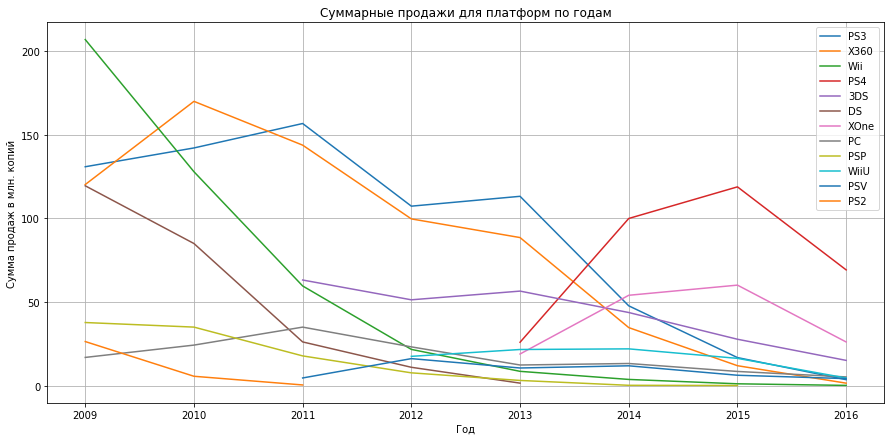

In [16]:
plt.figure(figsize=(15,7))
plt.title('Суммарные продажи для платформ по годам')
for row in platforms_data['platform']:
    platform = fresh_data.query("platform == @row").pivot_table(index='year_of_release', values='all_sales', aggfunc='sum').reset_index()
    sb.lineplot(data=platform, x='year_of_release', y='all_sales', label=row)
plt.xlabel('Год')
plt.ylabel('Сумма продаж в млн. копий')
plt.grid()
plt.show()

### Вывод
Между 2013 и 2015 годом виден рост продаж игр на PS4 и XBoxOne, в то время как остальные платформы теряют свою популярность. В 2016 график падает, вероятно, из-за того что данные за 2016 год не полные. Кроме PS4 и XBoxOne еще можно рассматривать платформу PC, т.к. она сохраняет стабильность.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по выбранным нами платформам.

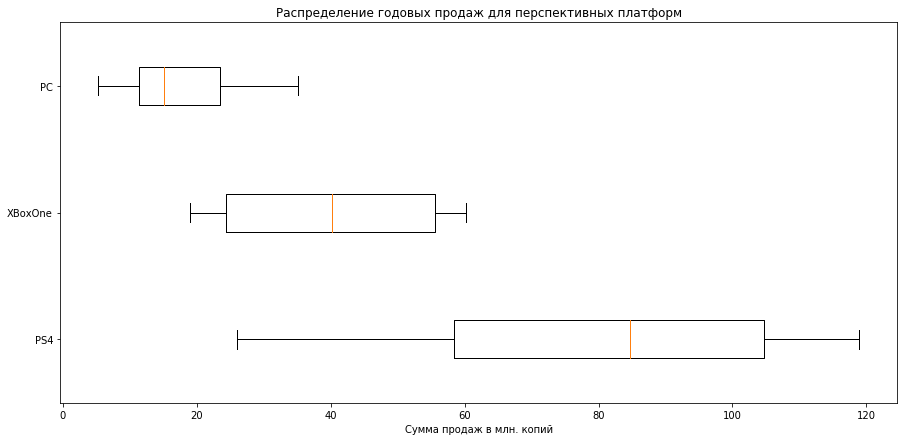

In [17]:
ps4 = fresh_data.query("platform == 'PS4'").pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')['all_sales']
xone = fresh_data.query("platform == 'XOne'").pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')['all_sales']
pc = fresh_data.query("platform == 'PC'").pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')['all_sales']
plt.figure(figsize=(15,7))
plt.title('Распределение годовых продаж для перспективных платформ')
plt.xlabel('Сумма продаж в млн. копий')
plt.boxplot((ps4,xone,pc), vert=False, labels=['PS4','XBoxOne','PC'])
plt.show()

### Вывод
Как и ожидалось, показатели продаж для PC имеют довольно низкие значения. А вот среди двух лидеров-консолей вперед выбивается PS4 с продажами примерно в 2 раза больше, чем на XboxOne, но при этом она имеет сильный разброс суммарной годовой прибыли. 

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
Рассмотрим PS4. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

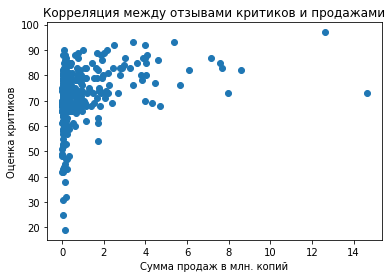

Коэффициент корреляции между отзывами критиков и продажами 0.35140802447758474


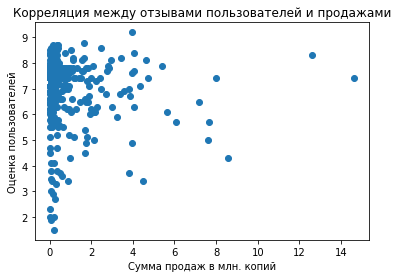

Коэффициент корреляции между отзывами пользователей и продажами -0.06548195077585679


In [18]:
ps4_data = fresh_data.query("platform == 'PS4'")
plt.plot(ps4_data['all_sales'], ps4_data['critic_score'], 'o')
plt.xlabel('Сумма продаж в млн. копий')
plt.ylabel('Оценка критиков')
plt.title('Корреляция между отзывами критиков и продажами')
plt.show()
print('Коэффициент корреляции между отзывами критиков и продажами',ps4_data['all_sales'].corr(ps4_data['critic_score']))
plt.plot(ps4_data['all_sales'], ps4_data['user_score'], 'o')
plt.xlabel('Сумма продаж в млн. копий')
plt.ylabel('Оценка пользователей')
plt.title('Корреляция между отзывами пользователей и продажами')
plt.show()
print('Коэффициент корреляции между отзывами пользователей и продажами',ps4_data['all_sales'].corr(ps4_data['user_score']))

### Вывод
Коэффициент корреляции между отзывами критиков и продажами равный 0.35 говорит нам о том, что между столбцами есть умеренная положительная связь. То есть удтверждение о том, что игры с большими рейтингами от критиков лучше продаются, имеет место быть в какой-то мере.

А вот коэффициент корреляции между отзывами пользователей и продажами почти равен 0, то есть связи никакой не наблюдается.

Посмотрим на ситуацию с XBoxOne:

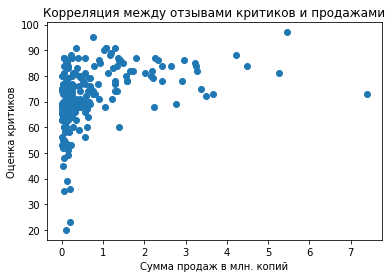

Коэффициент корреляции между отзывами критиков и продажами 0.3786581617346427


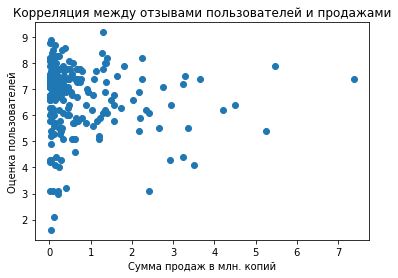

Коэффициент корреляции между отзывами пользователей и продажами -0.10515664470960723


In [19]:
xone_data = fresh_data.query("platform == 'XOne'")
plt.plot(xone_data['all_sales'], xone_data['critic_score'], 'o')
plt.xlabel('Сумма продаж в млн. копий')
plt.ylabel('Оценка критиков')
plt.title('Корреляция между отзывами критиков и продажами')
plt.show()
print('Коэффициент корреляции между отзывами критиков и продажами',xone_data['all_sales'].corr(xone_data['critic_score']))
plt.plot(xone_data['all_sales'], xone_data['user_score'], 'o')
plt.xlabel('Сумма продаж в млн. копий')
plt.ylabel('Оценка пользователей')
plt.title('Корреляция между отзывами пользователей и продажами')
plt.show()
print('Коэффициент корреляции между отзывами пользователей и продажами',xone_data['all_sales'].corr(xone_data['user_score']))

Коэффициент корреляции между отзывами критиков и продажами имеет даже чуть большее значение. А вот коэффициент корреляции между отзывами пользователей и продажами сдвинулся в отрицательную сторону, но все еще имеет малое значение.

Теперь сравним с PC:

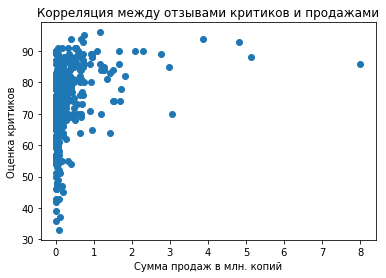

Коэффициент корреляции между отзывами критиков и продажами 0.3128168853271125


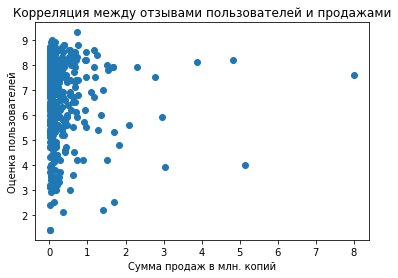

Коэффициент корреляции между отзывами пользователей и продажами -0.04550335196070034


In [20]:
pc_data = fresh_data.query("platform == 'PC'")
plt.plot(pc_data['all_sales'], pc_data['critic_score'], 'o')
plt.xlabel('Сумма продаж в млн. копий')
plt.ylabel('Оценка критиков')
plt.title('Корреляция между отзывами критиков и продажами')
plt.show()
print('Коэффициент корреляции между отзывами критиков и продажами',pc_data['all_sales'].corr(pc_data['critic_score']))
plt.plot(pc_data['all_sales'], pc_data['user_score'], 'o')
plt.xlabel('Сумма продаж в млн. копий')
plt.ylabel('Оценка пользователей')
plt.title('Корреляция между отзывами пользователей и продажами')
plt.show()
print('Коэффициент корреляции между отзывами пользователей и продажами',pc_data['all_sales'].corr(pc_data['user_score']))

### Вывод
Для всех трех платформ ситуация схожая: между отзывами критиков и продажами равный есть умеренная положительная связь. То есть игры с большими рейтингами от критиков вполне могут лучше продаваться. А вот связи между отзывами пользователей и продажами можно считать что нет.

### Посмотрим на общее распределение игр по жанрам.

In [21]:
genre_data = fresh_data.pivot_table(index='genre', values='all_sales', aggfunc='mean').sort_values(by='all_sales',ascending=False)
genre_data

,all_sales
genre,
Shooter,1.098060
Platform,0.880495
Sports,0.614459
Role-Playing,0.540373
Racing,0.487134
Action,0.458846
Fighting,0.450357
Misc,0.396893
Simulation,0.307853


### Вывод
Жанры шутер, платформер и спорт имеют самые высокие средние продажи. А вот пазлы стратегии и приключения - самые низкие. Популярность шутеров и платформеров обусловлена, вероятно, высоким уровнем впечатлений и экшена по мере игры, а так же тем, что эти жанры появились одни из первых и до сих пор остаются очень популярными.

## Шаг 4. Составим портрет пользователя каждого региона

Определим самые популярные платформы для пользователя каждого региона (NA, EU, JP):

In [22]:
print("NA:")
print(fresh_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales',ascending=False).head())
print("\nEU:")
print(fresh_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales',ascending=False).head())
print("\nJP:")
print(fresh_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales',ascending=False).head())

NA:
          na_sales
platform          
X360        408.18
PS3         291.90
Wii         235.75
DS          120.61
PS4         108.74

EU:
          eu_sales
platform          
PS3         255.00
X360        196.72
PS4         141.09
Wii         124.22
PC           82.32

JP:
          jp_sales
platform          
3DS         100.62
PS3          68.29
DS           52.11
PSP          50.39
Wii          34.32


### Вывод
В Северной Америке XBox360 обходит по продажам PS3, а в Европе наоборот. PS4  в обеих регионах только набирает популярность, т.к. она еще свежая. В Японии же XBox360 вообще не попадает в топ, а PS3 с первого места сдвигает Nintendo 3DS. Связано это с тем, что XBox создан в Америке, а PS и Nintendo - в Японии.

Теперь определим самые популярные жанры для пользователя каждого региона (NA, EU, JP):

In [23]:
print("NA:")
print(fresh_data.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales',ascending=False).head())
print("\nEU:")
print(fresh_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales',ascending=False).head())
print("\nJP:")
print(fresh_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales',ascending=False).head())

NA:
              na_sales
genre                 
Action          361.72
Shooter         276.37
Sports          227.66
Misc            164.40
Role-Playing    130.83

EU:
              eu_sales
genre                 
Action          271.91
Shooter         192.30
Sports          158.51
Misc             86.27
Role-Playing     83.56

JP:
              jp_sales
genre                 
Role-Playing    120.61
Action           84.16
Misc             30.09
Sports           25.32
Platform         20.65


### Вывод
В NA и EU предпочитаемые жанры совпадают, а вот в Японии в топ вырывается жанр ролевых игр. 

Проверим влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [24]:
print("NA:")
print(fresh_data.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales',ascending=False).head())
print("\nEU:")
print(fresh_data.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales',ascending=False).head())
print("\nJP:")
print(fresh_data.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales',ascending=False).head())

NA:
        na_sales
rating          
M         452.92
E         410.39
T         233.82
E10+      206.62
EC          1.83

EU:
        eu_sales
rating          
M         339.29
E         264.75
T         159.04
E10+      125.26
RP          0.03

JP:
        jp_sales
rating          
E          62.43
T          56.86
M          37.28
E10+       21.22
EC          0.00


### Вывод
В Северной Америке и Европе предпочитают игры с рейтингом М - "для взрослых". А вот в Японии особой популярностью этот жанр не обладает.

**Если пытаться составить портрет игрока по региону, то:**
* для NA и EU: пользователь предпочитает шутеры или экшены с возрастным ограничением "М" и играет на XBox360 или PS3.
* для JP: предпочитает играть в ролевые игры или экшены на Nintendo 3DS или PS3.

## Шаг 5. Проверим гипотезы

Возьмем уровень значимости 0.05.

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Составим нулевую и альтернативную гипотезы:
* H0: матожидания пользовательских рейтингов платформ Xbox One и PC одинаковые.
* H1: разные.

Проверяем гипотезы с помощью T-test для независимых выборок с разной дисперсией:

In [25]:
alpha = 0.05
rezult = sps.ttest_ind(xone_data['user_score'],pc_data['user_score'],equal_var=False)
print("pvalue =",rezult.pvalue)
if rezult.pvalue < alpha:
    print("Нулевая гипотеза отклоняется")
else:
    print("Нулевая гипотеза не отклоняется")    

pvalue = 0.4150364642312283
Нулевая гипотеза не отклоняется


Нулевая гипотеза не отклоняется, то есть имеются основания полагать, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

Составим нулевую и альтернативную гипотезы:
* H0: матожидания пользовательских рейтингов жанров Action и Sports равны.
* H1: разные.

Проверяем гипотезы тоже с помощью T-test для независимых выборок с разной дисперсией:

In [26]:
action_data = fresh_data.query("genre == 'Action'")
sports_data = fresh_data.query("genre == 'Sports'")
rezult = sps.ttest_ind(action_data['user_score'],sports_data['user_score'],equal_var=False)
print("pvalue =",rezult.pvalue)
if rezult.pvalue < alpha:
    print("Нулевая гипотеза отклоняется")
else:
    print("Нулевая гипотеза не отклоняется")

pvalue = 4.073652544679895e-11
Нулевая гипотеза отклоняется


Нулевая гипотеза отклоняется, то есть с наибольшей вероятностью средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

Нам были доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нам нужно было выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В начале были изучены и подготовлены данные для исследования. Таблица содержала 16715 записей и 11 столбцов. Сначала столбцы были переименованы в нижний регистр. Затем были удалены две записи почти не содержащие информации.

Столбец с годом выхода игры содержит 269 пропусков. Это менее 2-х процентов данных. Возможно, у некоторых записей просто потеряны данные, а у некоторых год содержится внутри названия игры. Было решено оставить эти строки как есть. 

Затем пропуски в данных об отзывах пользователей и критиков были заменены на медианное значение по жанру игры. В данных об оценках пользователей встретилось значение tbd - to be determined, которое означает, что оценка еще не готова. Эти значения тоже были заменены. Заодно был изменен тип данных столбца отзывов пользователей на числовой.

Затем была попытка заменить пропуски в возрастном рейтинге. Было предположено, что некоторые игры указаны несколько раз на разных платформах и на каких-то из них стоит рейтинг. После проведения такого заполнения удалось избавиться от 400 пропусков. Остальные пропуски были оставлены как есть.

Был заменен тип данных в столбцах "год выпуска игры" и "рейтинг критиков" на целочисленный. Также в таблицу были добавлены суммарные продажи по всем регионам.

В начале исследования данных была построена гистограмма распределения игр по годам. По гистограмме видно, что объем игр, выпущенных до 2000-ных намного меньше, чем после. Начиная с 2002 года количество выпущенных игр начинает возрастать в разы.

Затем мы занялись поиском перспективных платформ. Для этого сначала были выделены топ-10 платформ по суммарым продажам и для них построены графики изменения количества продаж по годам. По графикам видно, что период актуальности для платформ составляет примерно 6-7 лет. Особенно это видно по смене поколений платформы PS(PS, PS2, PS3, PS4). Исключением является платформа PC, имеющая равномерные продажи. Исходя из предположения, что актуальность платформы имеют в среднем 6-7 лет, были выделены данные за последние 7 лет (2009-2016). 

Для этих данных был построен рейтинг суммарных продаж для каждой платформы, а затем и графики распределения продаж по годам. По графику видно, что между 2013 и 2015 годом идет рост продаж игр на PS4 и XBoxOne, в то время как остальные платформы теряют свою популярность. В 2016 график падает, вероятно, из-за того что данные за 2016 год не полные. Кроме PS4 и XBoxOne еще можно рассматривать платформу PC, т.к. она сохраняет стабильность. Таким образом были выделены три потенциально прибыльные платформы.

Для выбранных нами трех платформ были построены диаграммы размаха. Как и ожидалось, показатели продаж для PC имеют довольно низкие значения. А вот среди двух лидеров-консолей вперед выбивается PS4 с продажами примерно в 2 раза больше, чем на XboxOne, хотя при этом имеет намного больший разброс значений.

Затем мы проверили как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Для трех перспективных платформ были построены диаграммы рассеяния и посчитаны коэффициенты корреляции между отзывами и продажами. Для всех трех платформ ситуация схожая: между отзывами критиков и продажами равный есть умеренная положительная связь(коэф. корреляции ~0.3-0.4). То есть игры с большими рейтингами от критиков вполне могут лучше продаваться. А вот связи между отзывами пользователей и продажами можно считать что нет(коэф. корреляции ~0).

После было изучено распределение продаж по жанрам. Жанры шутер, платформер и спорт имеют самые высокие средние продажи. А вот пазлы стратегии и приключения - самые низкие. Популярность шутеров и платформеров обусловлена, вероятно, высоким уровнем впечатлений и экшена по мере игры, а так же тем, что эти жанры появились одни из первых и до сих пор остаются очень популярными.

Затем была попытка определить портрет пользователя для каждого региона. Были определены:
* Самые популярные платформы (топ-5).
* Самые популярные жанры (топ-5). 
* Влияние рейтинга ESRB на продажи в отдельном регионе.

В Северной Америке XBox360 обходит по продажам PS3, а в Европе наоборот. PS4 в обеих регионах только набирает популярность, т.к. она еще свежая. В Японии же XBox360 вообще не попадает в топ, а PS3 с первого места сдвигает Nintendo 3DS. Связано это с тем, что XBox создан в Америке, а PS и Nintendo - в Японии.

В NA и EU предпочитаемые жанры совпадают: экшен, шутеры, спорт. А вот в Японии в топ вырывается жанр ролевых игр.

В Северной Америке и Европе предпочитают игры с рейтингом М - "для взрослых". А вот в Японии особой популярностью этот жанр не обладает.

**Если пытаться составить портрет игрока по региону, то:**
* для NA и EU: пользователь предпочитает шутеры или экшены с возрастным ограничением "М" и играет на XBox360 или PS3.
* для JP: предпочитает играть в ролевые игры или экшены на Nintendo 3DS или PS3.

В конце были проверены статистические гипотезы:

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
* Средние пользовательские рейтинги жанров Action и Sports разные.

Гипотезы проверялись с помощью T-test'a для двух независимых выборок. Результаты теста:

* Первая гипотеза **не была отклонена**, то есть имеются основания полагать, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

* Вторая гипотеза **была отклонена**, то есть с наибольшей вероятностью средние пользовательские рейтинги жанров Action и Sports разные.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Выводы понятны и логичны, а самое главное подкреплены выявленными фактами.
       
В целом сам проект выполнен на хорошем уровне! На протяжении всей работы чувствуется глубина проработки задачи и это безусловный плюс для нас. Было использовано большое количество методов, которые будут помогать тебе в дальнейших проектах.
    
Не стоит забывать про оформление своей работы, это важный такой же важный этап. Рекомендую «не стесняться» использовать ячейки типа **markdown** там где нам необходимо отобразить свои размышления, в том числе с использованием дополнительной стилизации.
    
Успехов тебе в новых проектах! 
    
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Рекомендую посмотреть на дополнительную стилизацию ячеек типа **markdown**.
    
**Жирный**
*Курсив*
    
--- 

# Заголовок первого уровня

--- 
    
## Заголовок второго уровня
  
---  
Списки:
    
- один 
- два
- три
   
---
    
1. Раз
2. Раз раз
3. Раз два три
    
--- 
    
Отображение `переменных`
    

    
</div>